In [1]:
from instant_ack import *

%load_ext autoreload
%autoreload 2

2024-09-11 00:11:14.658 | INFO     | instant_ack.config:<module>:11 - PROJ_ROOT path is: /data/instant-ack


# Compute PTOs

In [2]:
def pto_table(rtt, first_rtt, val_range=pl.arange(1, 52, 1, eager=True)):
    iack_rtt = first_rtt
    default_rtt = rtt

    df = (
        pl.DataFrame({"sample": val_range, "RTT": [default_rtt] * len(val_range)})
        .with_row_index("id")
        .with_columns(
            var=pl.when(pl.col("id") == 0).then(pl.lit(iack_rtt / 2)),
            smoothed=pl.when(pl.col("id") == 0).then(pl.lit(iack_rtt)),
            max_ack_delay=pl.when(pl.col("id") == 0)
            .then(pl.lit(0))
            .otherwise(pl.lit(25)),
        )
    )

    prev = None
    variance = []
    smoothed_rtt = []
    for row in df.iter_rows(named=True):
        if prev is None:
            prev = row
            variance.append(row["var"])
            smoothed_rtt.append(row["smoothed"])
            continue

        row["var"] = 3 / 4 * prev["var"] + 1 / 4 * abs(prev["smoothed"] - row["RTT"])
        row["smoothed"] = 7 / 8 * prev["smoothed"] + 1 / 8 * row["RTT"]

        variance.append(row["var"])
        smoothed_rtt.append(row["smoothed"])

        prev = row

    df = (
        df.drop(["smoothed", "var"])
        .with_columns(
            pl.Series(name="smoothed", values=smoothed_rtt, dtype=pl.Float64),
            pl.Series(name="var", values=variance, dtype=pl.Float64),
        )
        .with_columns(
            PTO=pl.col("smoothed") + 4 * pl.col("var") + pl.col("max_ack_delay")
        )
    )

    return df

In [3]:
iack_improvement = 4
cat_name = "Server"
RTT = "RTT"
c_client_frontend_RTT = "Client-Frontend RTT"

all_df = []
for i in [
    9,
    25,
]:
    all_df.append(pto_table(i, i).with_columns(pl.lit("IACK").alias(cat_name)))

    all_df.append(
        pto_table(i, i + iack_improvement).with_columns(pl.lit("WFC").alias(cat_name))
    )

m_df = pl.concat(all_df).with_columns(
    pl.format("{} ms", pl.col(RTT)).alias(c_client_frontend_RTT)
)

### PTO evolution with RTT samples at constant RTT: Section 2, Figure 2

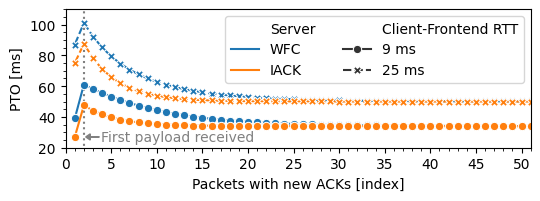

In [4]:
fig, ax = vh.fig_ax(figsize=(6, 1.8))

ax.vlines(2, 0, 200, ls=":", color="grey")

ax.arrow(
    3.7,
    27,
    -1.5,
    0,
    length_includes_head=True,
    head_width=4,
    head_length=0.5,
    color="grey",
)
ax.text(
    3.9,
    27,
    "First payload received",
    color="grey",
    verticalalignment="center",
)

ax = sns.lineplot(
    m_df.sort([cat_name, c_client_frontend_RTT], descending=[True, True]),
    x="sample",
    y="PTO",
    style=c_client_frontend_RTT,
    hue=cat_name,
    markers=True,
    palette="tab10",
)

ax.set(ylabel="PTO [ms]", xlabel="Packets with new ACKs [index]")
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.legend(ncol=2)
ax.set(ylim=(20, 110))
ax.set(xlim=(0, 51))

vh.save_plot(fig, f"lin_PTO_constant_RTT")
plt.show()